In [1]:
import pickle
from pathlib import Path

from scipy import ndimage as ndi
from skimage.color import label2rgb
from skimage.filters import try_all_threshold
from PIL import Image
import tifffile as tif
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

In [ ]:
#https://www.kaggle.com/code/marcosgabriel/dataset-intro-photovoltaic-system-o-m-inspection

In [2]:
SINGLE_ROW_METADATA_PATH = '../input/archive1/datasets/single-row/metadata.csv'
columns_to_rename = {'thermal image name': 'thermal_image_name'}

sr_metadata = (
    pd.read_csv(SINGLE_ROW_METADATA_PATH)
      .rename(columns=columns_to_rename)
)
sr_metadata.head()

timestamp  longitude   latitude thermal_image_name
0  2021-10-11 10:15:38.390  10.180881  49.613338  frame_000000.tiff
1  2021-10-11 10:15:38.480  10.180881  49.613338  frame_000001.tiff
2  2021-10-11 10:15:38.610  10.180881  49.613338  frame_000002.tiff
3  2021-10-11 10:15:38.750  10.180881  49.613338  frame_000003.tiff
4  2021-10-11 10:15:38.880  10.180881  49.613338  frame_000004.tiff

In [3]:
DOUBLE_ROW_METADATA_PATH = '../input/archive1/datasets/double-row/metadata.csv'
columns_to_rename = {
    'thermal image name': 'thermal_image_name',
    'rgb image name': 'rgb_image_name'
}

dr_metadata = (
    pd.read_csv(DOUBLE_ROW_METADATA_PATH)
      .rename(columns=columns_to_rename)
)
dr_metadata.head()

timestamp  longitude   latitude thermal_image_name  \
0  2021-10-11 10:29:44.540  10.180867  49.612644  frame_000000.tiff   
1  2021-10-11 10:29:44.550  10.180867  49.612644  frame_000001.tiff   
2  2021-10-11 10:29:44.680  10.180867  49.612644  frame_000002.tiff   
3  2021-10-11 10:29:44.810  10.180867  49.612644  frame_000003.tiff   
4  2021-10-11 10:29:44.950  10.180867  49.612644  frame_000004.tiff   

     rgb_image_name  
0  frame_000000.jpg  
1  frame_000001.jpg  
2  frame_000002.jpg  
3  frame_000003.jpg  
4  frame_000004.jpg

In [4]:
dr_metadata.shape

(2541, 5)

In [5]:
sr_metadata.shape

(5295, 4)

In [6]:
def get_image_full_path(image_name, image_type):    
    if image_type == 'single_row_thermal':
        origin_path = '../input/archive1/datasets/single-row/thermal images'
    elif image_type == 'double_row_thermal':
        origin_path = '../input/archive1/datasets/double-row/thermal images'
    elif image_type == 'double_row_rgb':
        origin_path = origin_path = '../input/archive1/datasets/double-row/rgb images'
    return Path(origin_path, image_name)


sr_metadata = (
    sr_metadata.assign(thermal_image_name=sr_metadata.thermal_image_name.apply(lambda x: get_image_full_path(x, 'single_row_thermal')))
               .assign(timestamp=pd.to_datetime(sr_metadata.timestamp))
)

dr_metadata = (
    dr_metadata.assign(thermal_image_name=dr_metadata.thermal_image_name.apply(lambda x: get_image_full_path(x, 'double_row_thermal')))
               .assign(rgb_image_name=dr_metadata.rgb_image_name.apply(lambda x: get_image_full_path(x, 'double_row_rgb')))
               .assign(timestamp=pd.to_datetime(sr_metadata.timestamp))
)

In [7]:
sr_metadata

timestamp  longitude   latitude  \
0    2021-10-11 10:15:38.390  10.180881  49.613338   
1    2021-10-11 10:15:38.480  10.180881  49.613338   
2    2021-10-11 10:15:38.610  10.180881  49.613338   
3    2021-10-11 10:15:38.750  10.180881  49.613338   
4    2021-10-11 10:15:38.880  10.180881  49.613338   
...                      ...        ...        ...   
5290 2021-10-11 10:27:24.390  10.180896  49.612621   
5291 2021-10-11 10:27:24.520  10.180896  49.612621   
5292 2021-10-11 10:27:24.660  10.180896  49.612621   
5293 2021-10-11 10:27:24.790  10.180896  49.612621   
5294 2021-10-11 10:27:24.920  10.180896  49.612621   

                                     thermal_image_name  
0     ../input/archive1/datasets/single-row/thermal ...  
1     ../input/archive1/datasets/single-row/thermal ...  
2     ../input/archive1/datasets/single-row/thermal ...  
3     ../input/archive1/datasets/single-row/thermal ...  
4     ../input/archive1/datasets/single-row/thermal ...  
...                                                 ...  
5290  ../input/archive1/datasets/single-row/thermal ...  
5291  ../input/archive1/datasets/single-row/thermal ...  
5292  ../input/archive1/datasets/single-row/thermal ...  
5293  ../input/archive1/datasets/single-row/thermal ...  
5294  ../input/archive1/datasets/single-row/thermal ...  

[5295 rows x 4 columns]

In [8]:
class Thermogram:
    
    def __init__(self, path: Path):
        self.path = path
    
    @property
    def celsius(self) -> np.ndarray:
        return (tif.imread(self.path.as_posix()) * 0.04) - 273.15
    
    def render(self) -> np.ndarray:
        image = self.celsius
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        return  (image * 255.0).astype(np.uint8)

def load_image(image_path: Path):
    image_format = image_path.suffix
    if image_format == '.jpg':
        return cv2.imread(image_path.as_posix())
    elif image_format == '.tiff':
        return Thermogram(image_path)

In [9]:
image_number = 57

thermogram = load_image(sr_metadata.thermal_image_name[image_number])



In [10]:
thermogram.celsius

array([[5.37, 5.81, 5.25, ..., 7.13, 7.25, 6.89],
       [4.85, 5.09, 5.65, ..., 6.97, 6.89, 6.93],
       [5.21, 5.33, 5.45, ..., 6.89, 6.73, 7.01],
       ...,
       [6.45, 6.37, 6.33, ..., 7.13, 7.29, 7.41],
       [5.61, 6.33, 6.13, ..., 7.37, 6.97, 7.45],
       [5.97, 6.13, 6.09, ..., 7.45, 7.21, 7.25]])

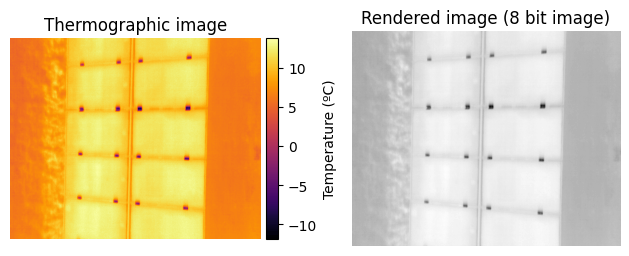

In [11]:
_, ax = plt.subplots(1, 2)

im = ax[0].imshow(thermogram.celsius, cmap='inferno')
ax[0].set_title('Thermographic image')
ax[0].set_axis_off()

ax[1].imshow(thermogram.render(), cmap='gray')
ax[1].set_title('Rendered image (8 bit image)')
ax[1].set_axis_off()

cax = make_axes_locatable(ax[0]).append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, values=np.unique(thermogram.celsius), label='Temperature (ºC)')
plt.tight_layout()
plt.show()

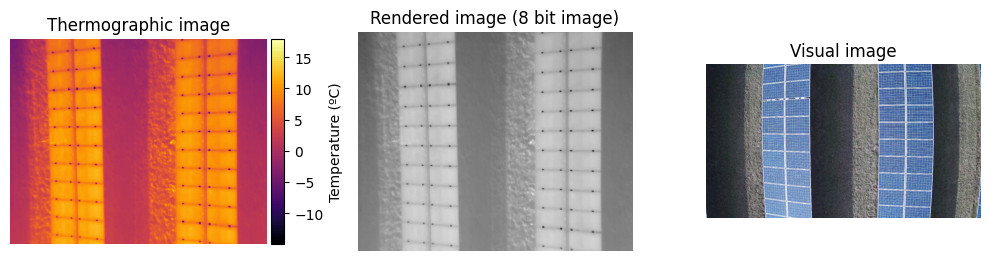

In [12]:
thermogram = load_image(dr_metadata.thermal_image_name[image_number])
visual = load_image(dr_metadata.rgb_image_name[image_number])

_, ax = plt.subplots(1, 3, figsize=(10,5))

im = ax[0].imshow(thermogram.celsius, cmap='inferno')
ax[0].set_title('Thermographic image')
ax[0].set_axis_off()

ax[1].imshow(thermogram.render(), cmap='gray')
ax[1].set_title('Rendered image (8 bit image)')
ax[1].set_axis_off()

ax[2].imshow(visual[:, :, ::-1])
ax[2].set_title('Visual image')
ax[2].set_axis_off()

cax = make_axes_locatable(ax[0]).append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, values=np.unique(thermogram.celsius), label='Temperature (ºC)')
plt.tight_layout()
plt.show()

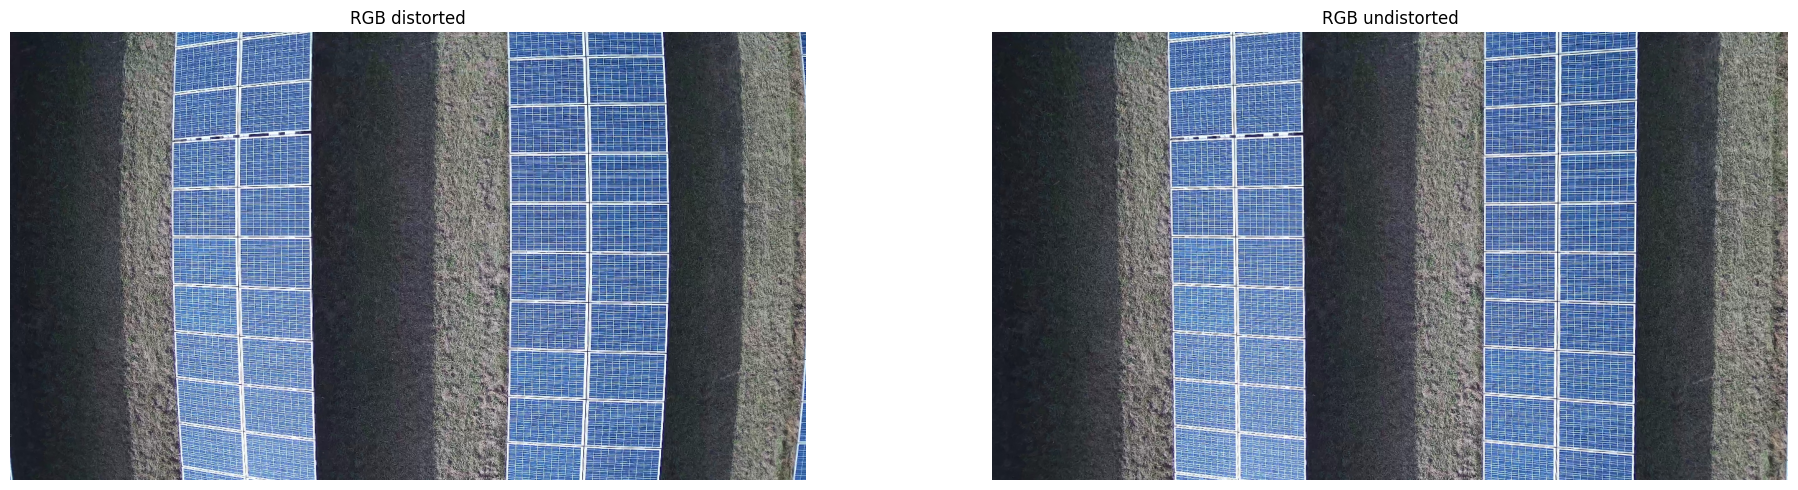

In [16]:
def remove_distortion(image: np.ndarray, image_type: str='rgb'):
    mapx_path = '../input/archive1/calibration files/RGB/mapx.pkl'
    mapy_path = '../input/archive1/calibration files/RGB/mapy.pkl'
    
    if image_type == 'ir':
        mapx_path = '../input/archive1/calibration files/IR/mapx.pkl'
        mapy_path = '../input/archive1/calibration files/IR/mapy.pkl'
    
    with open(mapx_path, 'rb') as mapx_file, open(mapy_path, 'rb') as mapy_file:
        mapx = pickle.load(mapx_file)
        mapy = pickle.load(mapy_file)

    return cv2.remap(image, mapx, mapy, cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
undistorted_rgb = remove_distortion(visual)

_, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].imshow(visual[:,:,::-1])
ax[0].set_title('RGB distorted')
ax[0].set_axis_off()

ax[1].imshow(undistorted_rgb[:,:,::-1])
ax[1].set_title('RGB undistorted')
ax[1].set_axis_off()

plt.tight_layout()
plt.show()

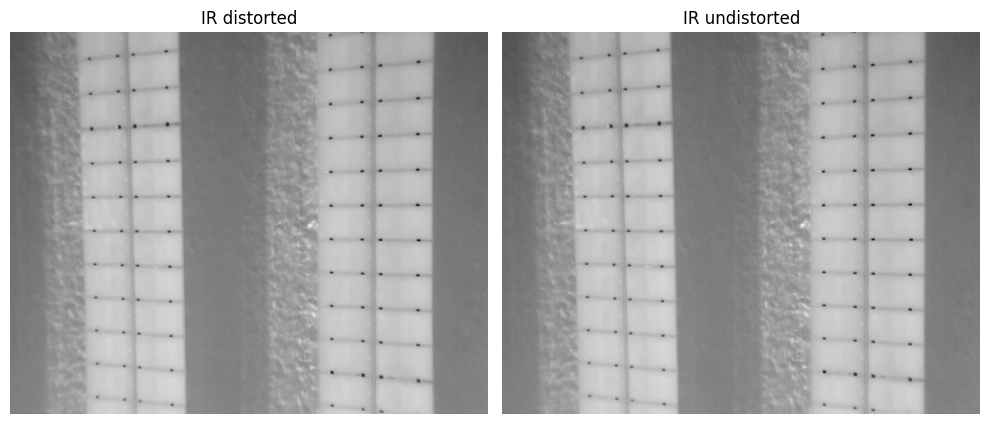

In [17]:
undistorted_ir = remove_distortion(thermogram.render(), 'ir')

_, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(thermogram.render(), cmap='gray')
ax[0].set_title('IR distorted')
ax[0].set_axis_off()

ax[1].imshow(undistorted_ir, cmap='gray')
ax[1].set_title('IR undistorted')
ax[1].set_axis_off()

plt.tight_layout()
plt.show()

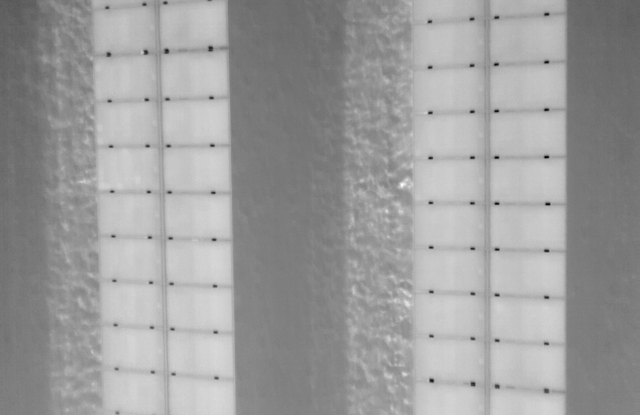

In [18]:
left = 0
top = 75
right = 640
bottom = 490

crop_fg_image = Image.fromarray(undistorted_ir).crop((left, top, right, bottom))
crop_fg_image

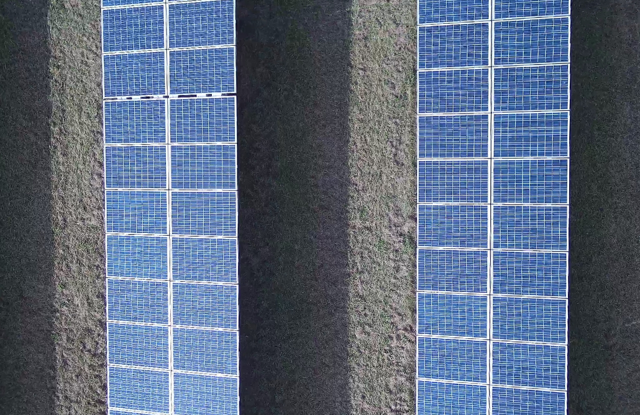

In [19]:
left = 120
top = 0
right = 1150
bottom = 720

crop_bg_image = Image.fromarray(undistorted_rgb[:,:,::-1]).crop((left, top, right, bottom)).resize(crop_fg_image.size)
crop_bg_image

In [20]:
def get_gradient(image):
    grad_x = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)
    return cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)

def align_images(
    image_1, image_2,
    warp_mode,
    n_iterations=5000,
    increment_threshold=1e-10
):
    warp_mode = cv2.MOTION_TRANSLATION
    if warp_mode == cv2.MOTION_HOMOGRAPHY:
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else:
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        
    criteria = (
        cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,
        n_iterations,
        increment_threshold
    )
    
    grad_1 = get_gradient(image_1)
    grad_2 = get_gradient(image_2)
    cc, warp_matrix = cv2.findTransformECC (
        grad_1, grad_2, 
        warp_matrix,
        warp_mode,
        criteria
    )
    
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        return cv2.warpPerspective(
            image_2,
            warp_matrix, 
            image_1.shape[::-1], 
            flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP
        )
    else:
        return cv2.warpAffine(
            image_2,
            warp_matrix,
            image_1.shape[::-1],
            flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP
        )
    
def blend_images(image_1, image_2, alpha=0.2, beta=None):
    beta = 1 - alpha if not beta else beta
    return cv2.addWeighted(image_2, alpha, image_1, beta, 0.0)

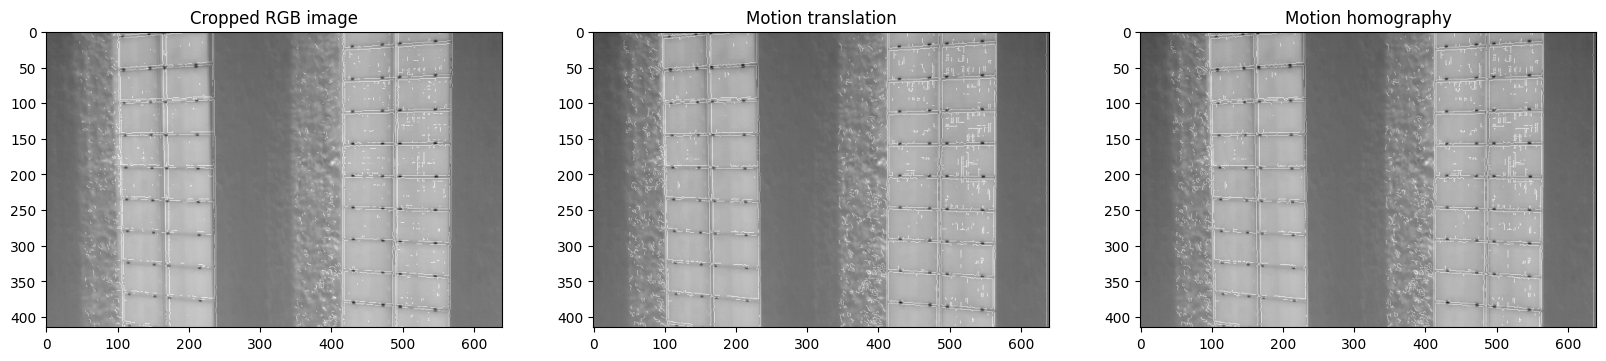

In [21]:
crop_bg_image = np.asarray(crop_bg_image)
crop_fg_image = np.asarray(crop_fg_image)

crop_bg_image_gray = cv2.cvtColor(crop_bg_image, cv2.COLOR_BGR2GRAY)

# Align the image with two methods: Translation and Homography
align_image_1 = align_images(crop_fg_image, crop_bg_image_gray, cv2.MOTION_TRANSLATION)
align_image_2 = align_images(crop_fg_image, crop_bg_image_gray, cv2.MOTION_HOMOGRAPHY)

# Apply the Canny edge detector in the images
unalign_canny =  cv2.Canny(crop_bg_image_gray, 300, 400)
align_canny_1 =  cv2.Canny(align_image_1, 200, 300)
align_canny_2 =  cv2.Canny(align_image_2, 200, 300)

# Blend the Canny masks with the thermal imagem
unalign_blend = blend_images(crop_fg_image, unalign_canny)
align_blend_1 = blend_images(crop_fg_image, align_canny_1)
align_blend_2 = blend_images(crop_fg_image, align_canny_2)

_, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].imshow(unalign_blend, cmap='gray')
ax[0].set_title('Cropped RGB image')
ax[1].imshow(align_blend_1, cmap='gray')
ax[1].set_title('Motion translation')
ax[2].imshow(align_blend_2, cmap='gray')
ax[2].set_title('Motion homography')
plt.show()

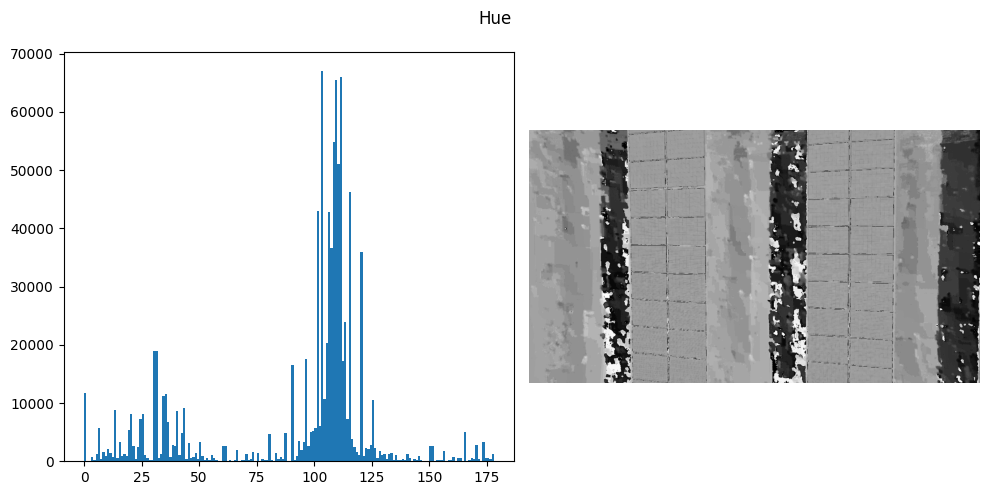

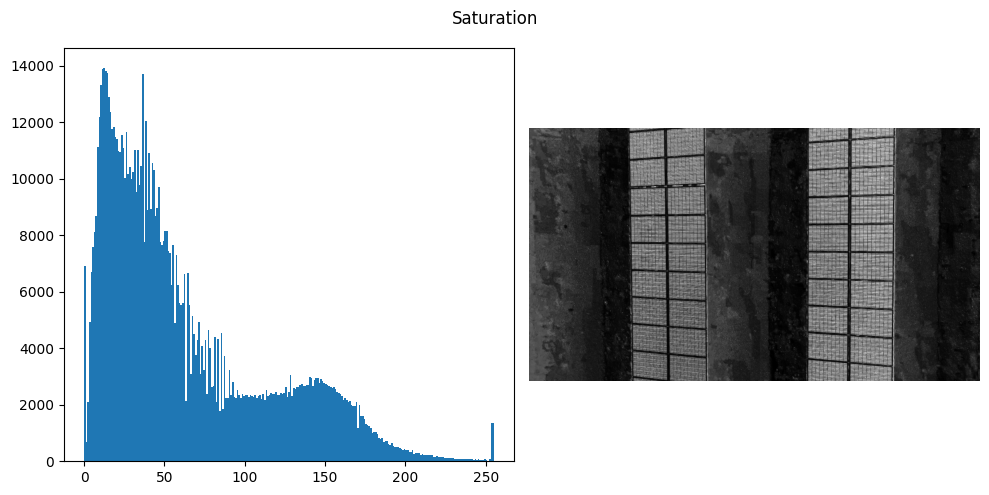

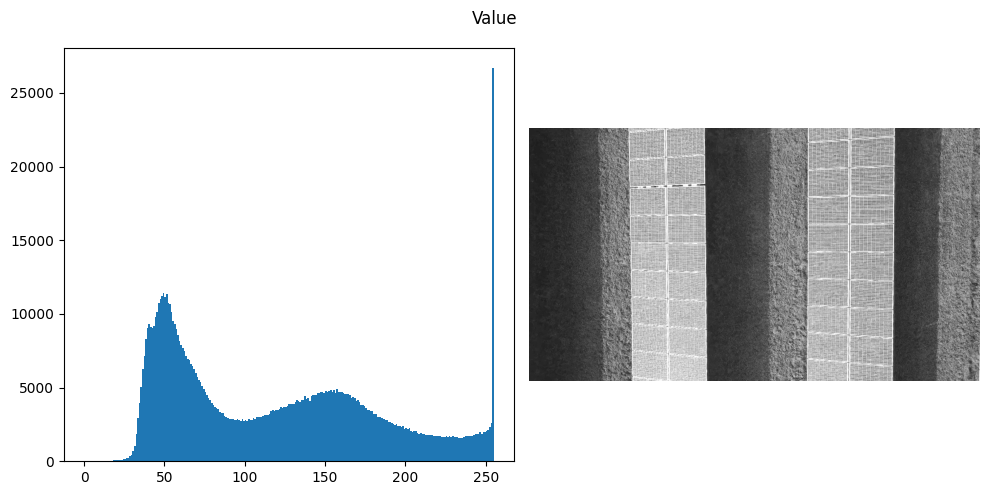

In [22]:
image = cv2.cvtColor(undistorted_rgb, cv2.COLOR_BGR2HSV)

for i in range(3):
    title = 'Value'
    if i == 0:
        title = 'Hue'
    elif i == 1:
        title = 'Saturation'
    
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    fig.suptitle(title)
    ax[0].hist(image[:,:,i].ravel(), np.unique(image[:,:,i]))
    ax[1].imshow(image[:,:,i], cmap='gray')
    ax[1].set_axis_off()
    plt.tight_layout()
plt.show()

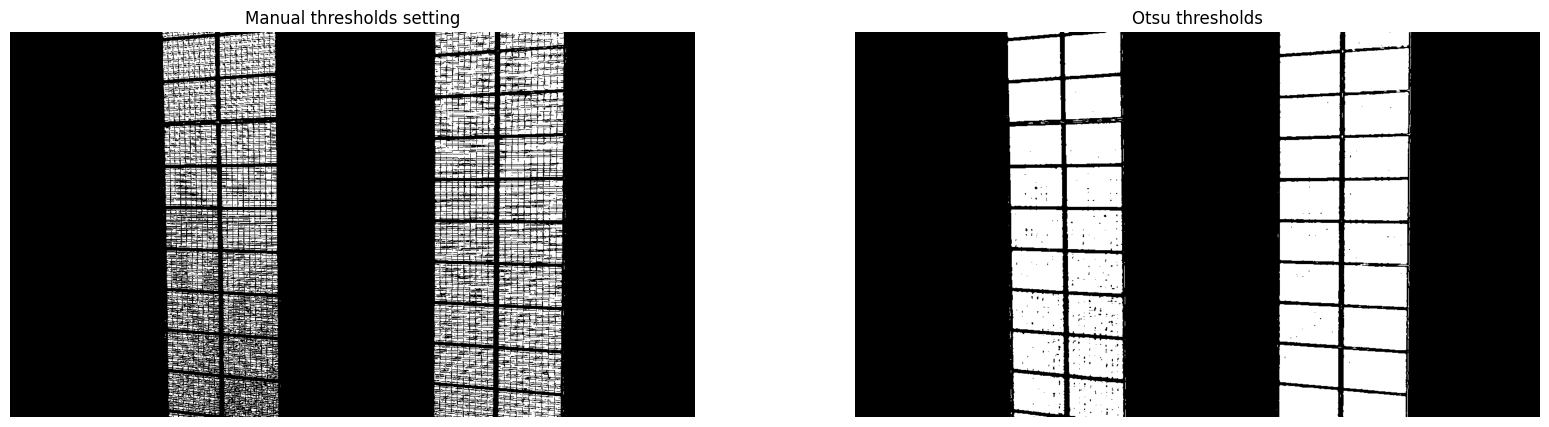

In [23]:
def preprocess_rgb_image_manual(image, lower_values, higher_values):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    return cv2.inRange(image, lower_values, higher_values)

def preprocess_rgb_image_hsv_otsu(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    masks = []
    for channel_index, channel_image in enumerate(cv2.split(image)):
        channel_image = cv2.GaussianBlur(channel_image, (5, 5), 0)
        max_value = 179 if channel_index == 0 else 255
        _, mask = cv2.threshold(
            channel_image, 0,
            max_value, cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )
        masks.append(mask)
    
    result_mask = np.bitwise_and(masks[0], masks[1])
    return np.bitwise_and(result_mask, masks[2])

lower_blue = np.array([90,100,100])
upper_blue = np.array([125,255,200])

mask_1 = preprocess_rgb_image_manual(undistorted_rgb, lower_blue, upper_blue)
mask_2 = preprocess_rgb_image_hsv_otsu(undistorted_rgb)

_, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].imshow(mask_1, cmap='gray')
ax[0].set_axis_off()
ax[0].set_title('Manual thresholds setting')
ax[1].imshow(mask_2, cmap='gray')
ax[1].set_title('Otsu thresholds')
ax[1].set_axis_off()
plt.show()

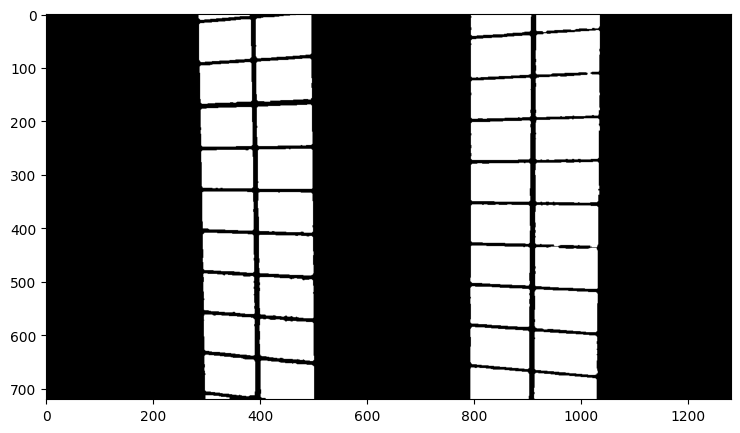

In [24]:
blur = cv2.medianBlur(mask_2, 5)

kernel = np.ones((5,5), np.uint8)
blur_open = cv2.morphologyEx(blur, cv2.MORPH_OPEN, kernel)

module_mask = ndi.binary_fill_holes(blur_open)

plt.figure(figsize=(10,5))
plt.imshow(module_mask, cmap='gray');

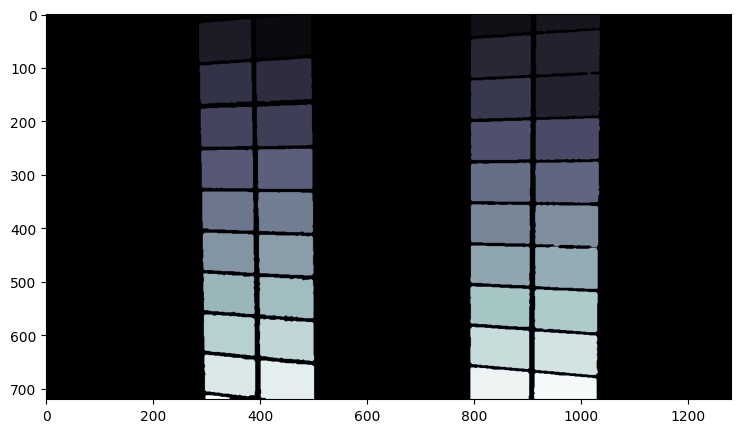

In [25]:
_, label_mask = cv2.connectedComponents(module_mask.astype('uint8'))
plt.figure(figsize=(10,5))
plt.imshow(label_mask, cmap='bone');

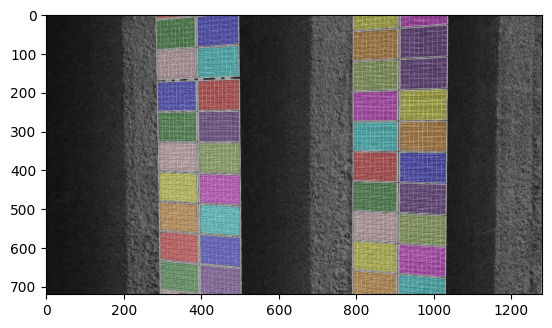

In [26]:
undistorted_gray = cv2.cvtColor(undistorted_rgb, cv2.COLOR_BGR2GRAY)
plt.imshow(label2rgb(label_mask, undistorted_gray));

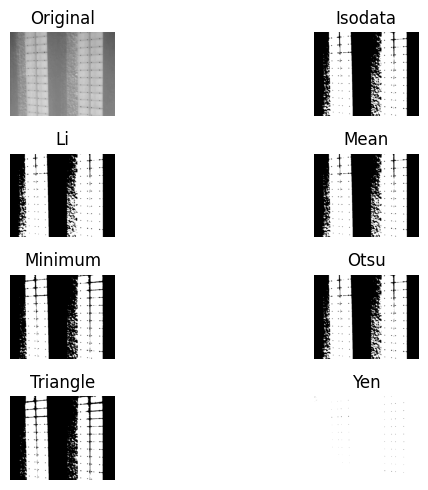

In [28]:
try_all_threshold(undistorted_ir, verbose=False);

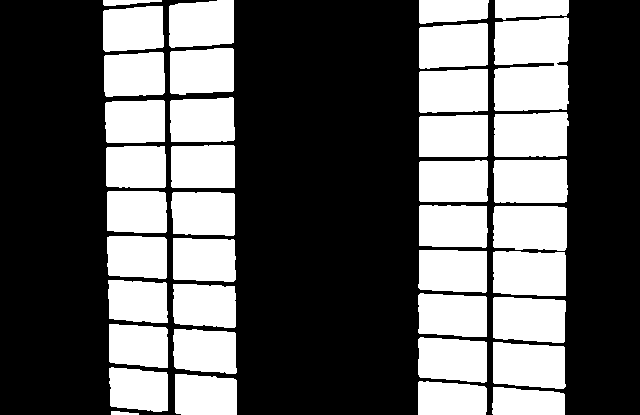

In [29]:
new_module_mask = (
    Image.fromarray(module_mask)
         .crop((120, 0, 1150, 720))
         .resize(crop_fg_image.shape[::-1])
)

new_module_mask

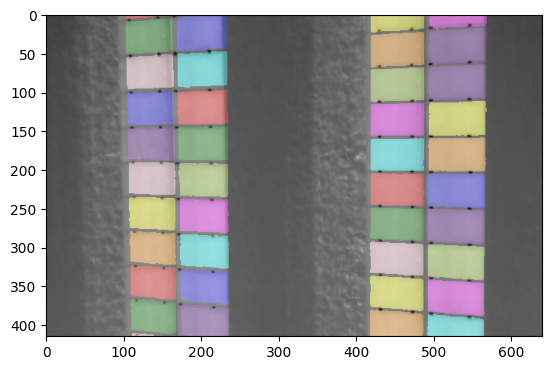

In [30]:

_, label_mask = cv2.connectedComponents(np.array(new_module_mask).astype('uint8'))
plt.imshow(label2rgb(label_mask, np.array(crop_fg_image)));

In [31]:
class ImageAligner:
    def __init__(self, number_features: int =500):
        self.feature_extractor = cv2.ORB_create(number_features)
        self.matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        self.points = {}
    
    def filter_matches(self, matches, matches_percent: float =0.2):
        matches = sorted(matches, key=lambda x: x.distance)
        matches_to_keep = int(len(matches) * matches_percent)
        return matches[:matches_to_keep]
        
    def __call__(self, image, template):
        # Get keypoints and descriptors
        image_kps, image_dsc = self.feature_extractor.detectAndCompute(image, None)
        template_kps, template_dsc = self.feature_extractor.detectAndCompute(template, None)
        
        # Match features and filter them
        matches = self.matcher.match(image_dsc, template_dsc)
        matches = self.filter_matches(matches)
        
        # Store points and matches for debug purposes
        self.points['keypoints'] = [image_kps, template_kps]
        self.points['matches'] = matches
        
        # Filter keypoints with filtered matches
        image_kps = np.float32([image_kps[match.queryIdx].pt for match in matches])
        template_kps = np.float32([template_kps[match.trainIdx].pt for match in matches])
        
        # Correct image perspective
        matrix, _ = cv2.findHomography(image_kps, template_kps, cv2.RANSAC)
        return cv2.warpPerspective(image, matrix, template.shape[::-1])
    
    def inspect_matches(self, image, template):
        return cv2.drawMatches(
            image, 
            self.points['keypoints'][0],
            template,
            self.points['keypoints'][1],
            self.points['matches'], 
            None
        )

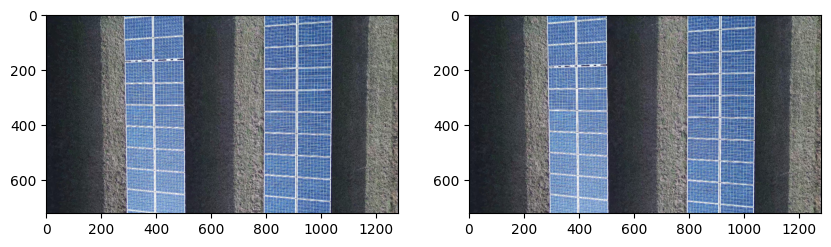

In [32]:
undistorted_rgb_1 = remove_distortion(load_image(dr_metadata.rgb_image_name[57]))
undistorted_rgb_2 = remove_distortion(load_image(dr_metadata.rgb_image_name[58]))

_, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(undistorted_rgb_1[:,:,::-1])
ax[1].imshow(undistorted_rgb_2[:,:,::-1])
plt.show()

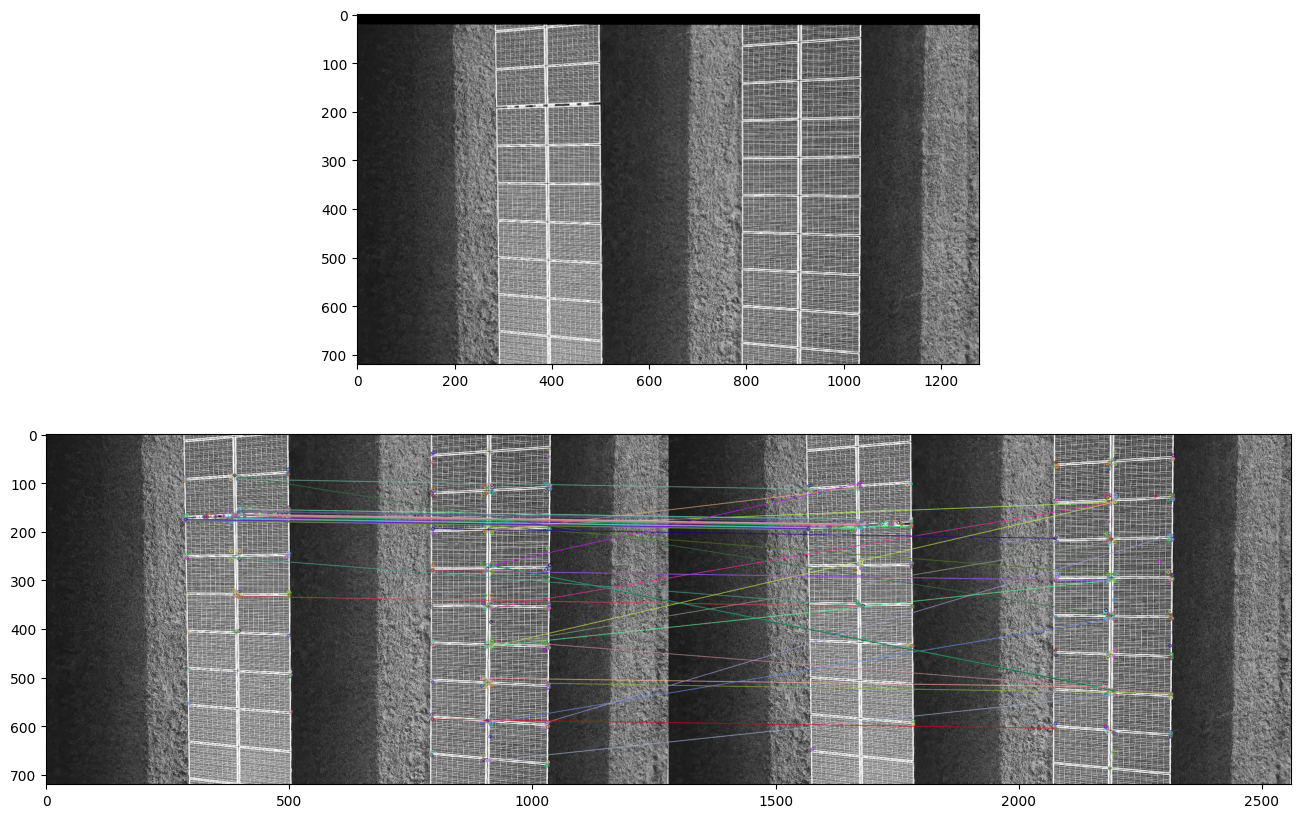

In [33]:
aligner = ImageAligner()

undistorted_gray_1 = cv2.cvtColor(undistorted_rgb_1, cv2.COLOR_BGR2GRAY)
undistorted_gray_2 = cv2.cvtColor(undistorted_rgb_2, cv2.COLOR_BGR2GRAY)

aligned_image = aligner(undistorted_gray_1, undistorted_gray_2)
inspected_image = aligner.inspect_matches(undistorted_gray_1, undistorted_gray_2)

_, ax = plt.subplots(2, 1, figsize=(20,10))
ax[0].imshow(aligned_image, cmap='gray')
ax[1].imshow(inspected_image)
plt.show()

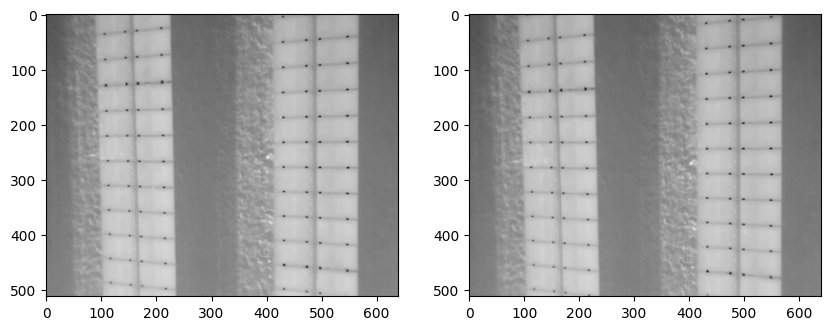

In [34]:
undistorted_ir_1 = remove_distortion(load_image(dr_metadata.thermal_image_name[57]).render(), 'ir')
undistorted_ir_2 = remove_distortion(load_image(dr_metadata.thermal_image_name[58]).render(), 'ir')

_, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(undistorted_ir_1, cmap='gray')
ax[1].imshow(undistorted_ir_2, cmap='gray')
plt.show()

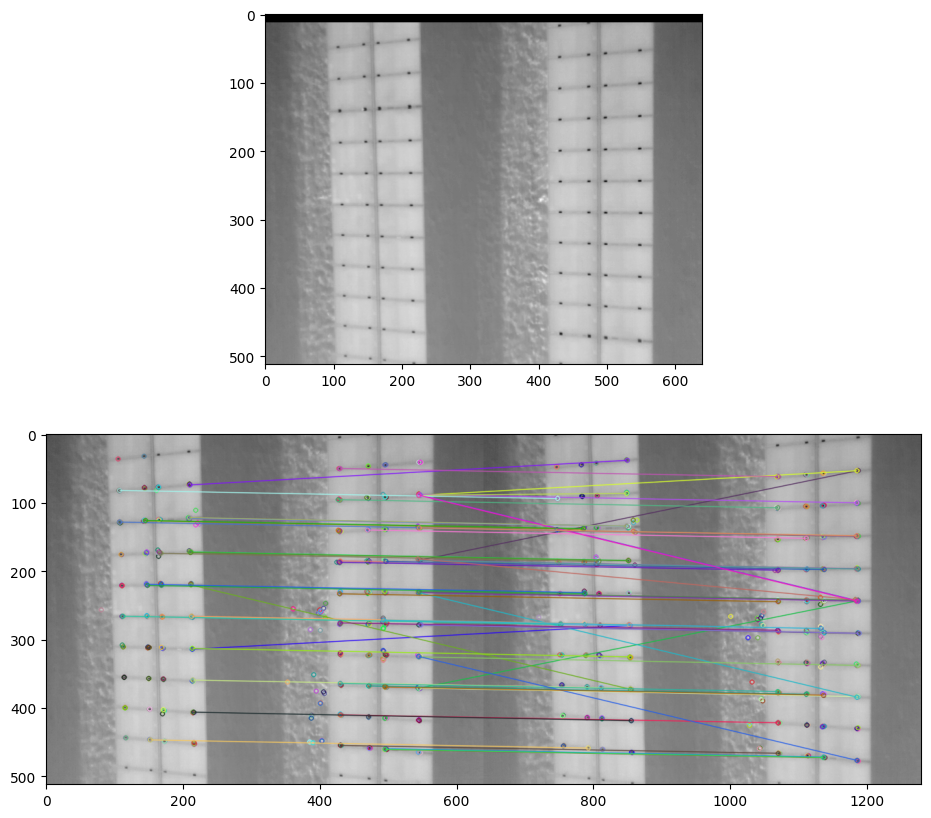

In [35]:
aligner = ImageAligner()

aligned_image = aligner(undistorted_ir_1, undistorted_ir_2)
inspected_image = aligner.inspect_matches(undistorted_ir_1, undistorted_ir_2)

_, ax = plt.subplots(2, 1, figsize=(20,10))
ax[0].imshow(aligned_image, cmap='gray')
ax[1].imshow(inspected_image)
plt.show()

In [36]:
sr_inspection_time = sr_metadata.timestamp.filter([0, 5294]).diff().iloc[1].seconds
dr_inspection_time = dr_metadata.timestamp.filter([0, 2540]).diff().iloc[1].seconds

print(f'Single row inspection time: {sr_inspection_time // 60} minutes and {sr_inspection_time % 60} seconds')
print(f'Double row inspection time: {dr_inspection_time // 60} minutes and {dr_inspection_time % 60} seconds')

Single row inspection time: 11 minutes and 46 seconds
Double row inspection time: 5 minutes and 38 seconds


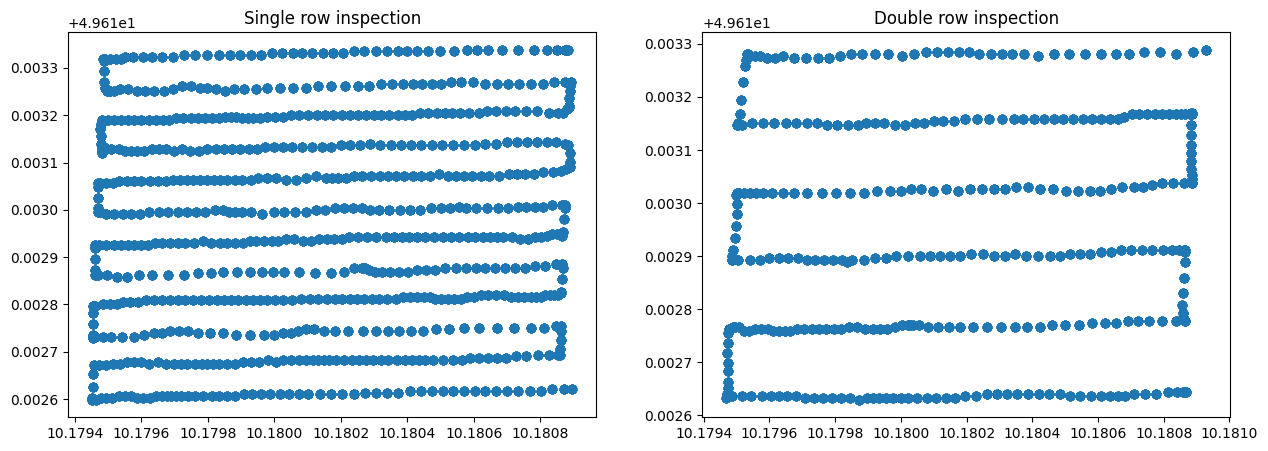

In [37]:
_, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].scatter(sr_metadata.longitude, sr_metadata.latitude)
ax[0].set_title('Single row inspection')
ax[1].scatter(dr_metadata.longitude, dr_metadata.latitude)
ax[1].set_title('Double row inspection')
plt.show()